## Importing modules

In [256]:


import numpy as np
import pandas as pd
import re
import string
from collections import Counter

from nltk import pos_tag
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE 

# Maybe try Gensim for LDA
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
#from gensim.corpora import Dictionary
#import gensim.matutils as matutils
#from gensim.models import LdaModel, Nmf, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import dill


## Functions for the project

In [3]:
def save_load(s_or_l, obj_name, file_name):
    saveorload = s_or_l
    if saveorload =='s':
        with open(file_name, 'wb') as f:
            dill.dump(obj_name, f)
            print(f'Obj saved as {file_name}')
    elif saveorload =='l':          
        with open(file_name, 'rb') as f:
            obj_name = dill.load(f)
            print(f'File {file_name} has been loaded as {obj_name}')
    else:
        print('Error')

In [4]:
# Building a wordcloud function for visual judgements 

#https://www.geeksforgeeks.org/generating-word-cloud-python/
def make_wc(dataset, image_name=''):

    wc_stopword = set(STOPWORDS)
    text_preprocess = ' '.join(dataset)
    wc = WordCloud(mode='RGBA', width = 900, height = 900, 
                        background_color ='white', min_word_length = 1,
                        stopwords = wc_stopword, min_font_size = 10).generate(text_preprocess)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wc) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    if image_name=='':
        pass
    else:
        plt.savefig(f'{image_name}.png') 
        
    plt.show()
    return wc

In [5]:
# For a given model 'model' that uses a vectorizer 'vectorizer', the function takes top n terms for each topic (default=10), and store them in a dictionary

def get_topic_terms(model, vectorizer, top_n_terms=10):

    print(f'Here are top {top_n_terms} most contributing terms for each topic:')
    print('\n')
    
    vect_feature_names = vectorizer.get_feature_names()
    topics_dict = {}
    for topic_num in range(len(model.components_)):
    
        topic_name = 'Topic #'+ str(topic_num+1) # Proprietary topic name
        top_term_indices = np.argsort(model.components_[topic_num,:])[::-1]   # Sorts terms in topic_num'th Topic. 
        top_terms = []
        for term_idx in top_term_indices[0:top_n_terms]:
            top_terms.append(vect_feature_names[term_idx])
        
            topics_dict[topic_name] = top_terms  # For each topic, take top n terms and put them into a list

        print(f'{topic_name}:')
        print(topics_dict[topic_name])
    
    
    return topics_dict

# 1. Importing CSV dataset

In [7]:
pd.set_option('display.max_columns', None)

In [425]:
df = pd.read_csv('recipes.csv', encoding='utf-8')
df_backup = df.copy()
df.shape

(522517, 28)

In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [427]:
df.head(3)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.5,10.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."


Check if there are null values in main features

In [428]:
pd.isna(df).sum()

RecipeId                           0
Name                               0
AuthorId                           0
AuthorName                         0
CookTime                       82545
PrepTime                           0
TotalTime                          0
DatePublished                      0
Description                        5
Images                             1
RecipeCategory                   751
Keywords                       17237
RecipeIngredientQuantities         3
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
R

Extract Recipes and Names and create a new dataframe to be used for topic modeling

In [429]:
df_recipe_raw = pd.DataFrame(df[['Name','RecipeInstructions']])
df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.str.lower()

In [430]:
df_recipe_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Name                522517 non-null  object
 1   RecipeInstructions  522517 non-null  object
dtypes: object(2)
memory usage: 8.0+ MB


# 2. Initial Data Cleaning

- Saving df_recipe_raw into a csv file.

In [431]:
df_recipe_raw_backup = df_recipe_raw.copy()

### Preliminary data cleaning

In [432]:
df_recipe_raw

,Name,RecipeInstructions
0,Low-Fat Berry Blue Frozen Dessert,"c(""toss 2 cups berries with sugar."", ""let stan..."
1,Biryani,"c(""soak saffron in warm milk for 5 minutes and..."
2,Best Lemonade,"c(""into a 1 quart jar with tight fitting lid, ..."
3,Carina's Tofu-Vegetable Kebabs,"c(""drain the tofu, carefully squeezing out exc..."
4,Cabbage Soup,"c(""mix everything together and bring to a boil..."
...,...,...
522512,Meg's Fresh Ginger Gingerbread,"c(""preheat oven to 350&deg;f grease an 8x8 cak..."
522513,Roast Prime Rib au Poivre with Mixed Peppercorns,"c(""position rack in center of oven and preheat..."
522514,Kirshwasser Ice Cream,"c(""heat half and half and heavy cream to a sim..."
522515,Quick & Easy Asian Cucumber Salmon Rolls,"c(""in a small bowl, combine mayo and wasabi pa..."


In [433]:
# Take a look at an example in order to identify strings that need to be cleaned.

df_recipe_raw.RecipeInstructions[0]

'c("toss 2 cups berries with sugar.", "let stand for 45 minutes, stirring occasionally.", "transfer berry-sugar mixture to food processor.", "add yogurt and process until smooth.", "strain through fine sieve. pour into baking pan (or transfer to ice cream maker and process according to manufacturers\' directions). freeze uncovered until edges are solid but centre is soft.  transfer to processor and blend until smooth again.", "return to pan and freeze until edges are solid.", "transfer to processor and blend until smooth again.", \n"fold in remaining 2 cups of blueberries.", "pour into plastic mold and freeze overnight. let soften slightly to serve.")'

In [434]:
# Removing unwanted strings that can't be removed via string.punctuation.
df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.map(lambda x: re.sub('c\(', '', x))
df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.map(lambda x: re.sub('\)', '', x))
df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.map(lambda x: re.sub('\\n', '', x))
df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.map(lambda x: re.sub('°', '', x))
# Removing punctuations using string.punctuation
df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# Removing integers
df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.map(lambda x: re.sub('[0-9]+', '', x))


<>:2: DeprecationWarning: invalid escape sequence \(
<>:3: DeprecationWarning: invalid escape sequence \)
<>:2: DeprecationWarning: invalid escape sequence \(
<>:3: DeprecationWarning: invalid escape sequence \)
C:\Users\HYOSAN~1\AppData\Local\Temp/ipykernel_23696/1843770375.py:2: DeprecationWarning: invalid escape sequence \(
  df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.map(lambda x: re.sub('c\(', '', x))
C:\Users\HYOSAN~1\AppData\Local\Temp/ipykernel_23696/1843770375.py:3: DeprecationWarning: invalid escape sequence \)
  df_recipe_raw.RecipeInstructions = df_recipe_raw.RecipeInstructions.map(lambda x: re.sub('\)', '', x))


- I am looking at a couple of documents as an examples to gain insights on how the cleaning perfomed

In [435]:
# Check if the unwanted strings are successfully removed.
df_recipe_raw.RecipeInstructions[1345]

'saute onion in butter until soft and golden do not brown add milk beaten eggs stir in remaining ingredients pour into a greased shallow quart baking dish and set in pan containing  inch of hot water bake in preheated slow oven  degrees for  minutes or until firm garnish with parsley sprigs cut in squares and serve hot'

#### Creating a corpus from the cleaned dataframe. 

In [436]:
# I am going to create a separate df called df_recipe for the rest of the modeling.
df_recipe = df_recipe_raw.copy()

- Converting the corpus into a list and then counting number of non-unique and unique terms 

In [437]:
corpus_recipe = list(df_recipe.RecipeInstructions)

total_terms = sum([len(d.split(' ')) for d in corpus_recipe])
print(f'Total number of terms in my corpus: {total_terms}')

Total number of terms in my corpus: 53637329


In [438]:
countee = Counter(corpus_recipe)
keys = countee.keys()
n_uniques = len(keys)
print(f'Total number of unique terms in my corpus:{n_uniques}')

Total number of unique terms in my corpus:519060


- So essentially I need to bring the dimensions down from 519,042 to something feasible.

### Lemm / Stemm
- Lemmatization was taking forever due to the size of the data, so I've only implemented a function for it.

In [52]:
df_recipe_test = df_recipe.copy()
#df_recipe_test.reset_index(inplace=True, drop='True')
df_recipe_test

,Name,RecipeInstructions,Topic
0,Low-Fat Berry Blue Frozen Dessert,toss s berries with sugar stand for s stirr...,Sauce
1,Biryani,soak saffron in warm milk for s and puree in ...,Chicken
2,Best Lemonade,into a quart jar with tight fitting lid put s...,Cool Bev
3,Carina's Tofu-Vegetable Kebabs,drain the tofu carefully squeezing out excess ...,Meat Dish
4,Cabbage Soup,mix everything together and to a boil reduce ...,Soup & Stew
...,...,...,...
522512,Meg's Fresh Ginger Gingerbread,preheat oven to degf grease an x cake pan this...,Dessert
522513,Roast Prime Rib au Poivre with Mixed Peppercorns,position rack in center of oven and preheat to...,Meat Dish
522514,Kirshwasser Ice Cream,heat half and half and heavy cream to a simmer...,Sauce
522515,Quick & Easy Asian Cucumber Salmon Rolls,in a bowl combine mayo and wasabi paste stir ...,Salad


In [60]:
print(nltk.pos_tag(['going']))

[('going', 'VBG')]


In [63]:
print(nltk.pos_tag(['going'])[0][1][0])

V


In [257]:
#lemmatizer = WordNetLemmatizer()

#corpus_recipe_lemm = corpus_recipe
#pos_tags = ['\'v\'', '\'j\'', '\'n\'',  '\'r\''] # verb, Adj, Noun, Adv

def lemm_docs(doc):
    lemmatizer = WordNetLemmatizer()
    word_list = word_tokenize(doc)
    
    lemm_list = []
    for word in word_list:
        if pos_tag([word])[0][1][0] == 'V':
            wordnet_pos = wordnet.VERB
        elif pos_tag([word])[0][1][0] == 'J':
            wordnet_pos = wordnet.ADJ           
        elif pos_tag([word])[0][1][0] == 'N':
            wordnet_pos = wordnet.NOUN            
        elif pos_tag([word])[0][1][0] == 'R':
            wordnet_pos = wordnet.ADV  
        else:
            wordnet_pos = wordnet.NOUN
        #print(word)
        #print(wordnet_pos)
        #print(lemmatizer.lemmatize(word, wordnet_pos))
        lemm_list.append(lemmatizer.lemmatize(word, wordnet_pos))
        #print('appended')
    lemm_doc = ' '.join(lemm_list)
        
    return lemm_doc


            
          #  lemm_doc = ' '.join([lemmatizer.lemmatize(word, wordnet.VERB) for word in word_list])
        

In [166]:
df_recipe_test['RecipeInstructions'] = df_recipe_test['RecipeInstructions'].apply(lemm_docs)

KeyboardInterrupt: 

- Stemming was applied, but, after a manual comparison, it ultimately was not utilized

In [56]:
def stem_docs(doc):
    stemmer = PorterStemmer()
    word_list = word_tokenize(doc)
    
    stems = [stemmer.stem(word) for word in word_list]
    stem_doc = ' '.join(stems)
    return stem_doc

In [57]:
df_recipe_test['RecipeInstructions'] = df_recipe_test['RecipeInstructions'].apply(stem_docs)

# 3. Vectorization

### Vectorizing the corpus(recipes) via TF-IDF

- Even two very different foods can share some of the ingredients. Yet, the frequency of mentioning said ingredients may differ from a dish to dish. Therefore, I determined that each terms have better chance of being represented properly when they are weighted, hence TF-IDF vectorizer. 

- The hyperparameters below are the result of tuning manually by going through the NMF result and checking if the topics show clear distinction (not having too many overlapping terms) and overally 'make sense'

In [446]:
#tfidf = TfidfVectorizer(stop_words='english', max_df=0.99, min_df=0.05)   #max_features=, ngram_range=(1,2)
tfidf = TfidfVectorizer(stop_words='english', max_df=0.22, min_df=0.015)
x_tfidf = tfidf.fit_transform(df_recipe.RecipeInstructions)
x_tfidf

<522517x478 sparse matrix of type '<class 'numpy.float64'>'
	with 11991305 stored elements in Compressed Sparse Row format>

In [30]:
save_load('s', tfidf, 'tfidf')
save_load('s', x_tfidf, 'x_tfidf')

Obj saved as tfidf
Obj saved as x_tfidf


The wordcloud below was used for an initial inspection of the terms.

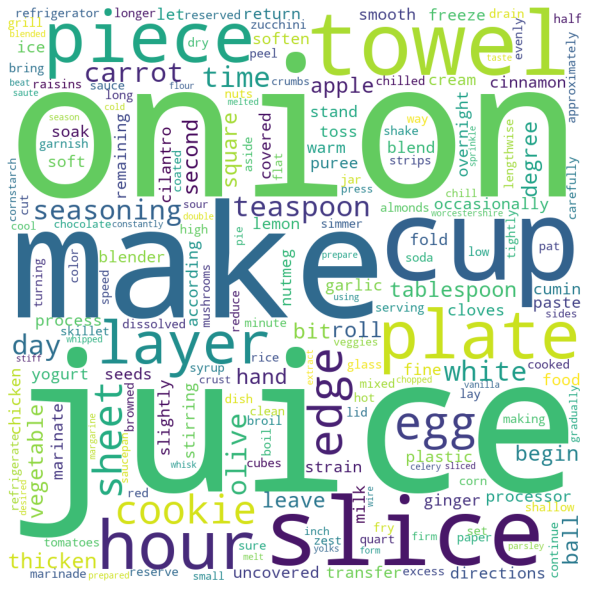

In [23]:
dtm_tfidf = pd.DataFrame(x_tfidf.toarray(), columns=tfidf.vocabulary_)
make_wc(dtm_tfidf.columns, 'test4')

### Data cleaning, second round
-After my initial topic modeling with NMF, I have returned to my dataframe and manually removed some terms that are deemed irrelevant or might occur too commonly in most recipes.  

In [440]:
bad_terms = ['minute','hour','day','medium','large','small','add', 'bring', 'let', 'make']

for terms in bad_terms:
    df_recipe.RecipeInstructions = df_recipe.RecipeInstructions.map(lambda x: re.sub(terms, '', x))

In [441]:
bad_terms2 = ['cup', 'slice', 'plate', 'towel']

for terms in bad_terms2:
    df_recipe.RecipeInstructions = df_recipe.RecipeInstructions.map(lambda x: re.sub(terms, '', x))

In [29]:
# Saving cleaned dataframe into a csv file.
df_recipe.to_csv('df_recipe_cleaned.csv', encoding='utf-8')

# 4. Topic modeling
- NMF and LDA were tried. Ultimately NMF was chosen for the main analysis

## 4a. NMF

In [442]:
df_recipe = pd.read_csv('df_recipe_cleaned.csv',  index_col=0)

In [456]:
topic_no = 11
iter_max = 500

nmf_sklearn = NMF(n_components=topic_no, max_iter = iter_max, init='nndsvd', shuffle=True, random_state=123)  #init='nndsvd', 

- My NMF model

In [457]:
recipe_model = nmf_sklearn.fit(x_tfidf) #Corresponds to 'W', TOPIC WEIGHTS for each document

In [458]:
model_term_weights = recipe_model.components_ # Corresponds to 'H', TERM WEIGHTS for each topic
recipe_model_transform = recipe_model.transform(x_tfidf) # This is for later use with topic fitting

print(recipe_model.n_components_)

11


In [34]:
with open("recipe_model","wb") as f:
    dill.dump(recipe_model, f)


In [453]:
with open('recipe_model', 'rb') as f:
    recipe_model = dill.load(f)

Let's look at the terms for each topic

In [460]:
topic_terms = get_topic_terms(recipe_model, tfidf)

Here are top 10 most contributing terms for each topic:


Topic #1:
['sauce', 'meat', 'grill', 'beef', 'pork', 'skil', 'soy', 'marinade', 'hot', 'garlic']
Topic #2:
['beat', 'cake', 'flour', 'cool', 'batter', 'chocolate', 'vanilla', 'eggs', 'egg', 'cream']
Topic #3:
['chicken', 'pieces', 'cooked', 'broth', 'marinade', 'rice', 'skil', 'coat', 'dish', 'bag']
Topic #4:
['cheese', 'dish', 'cream', 'sprinkle', 'casserole', 'spread', 'melted', 'layer', 'sour', 'degrees']
Topic #5:
['dough', 'roll', 'sheet', 'cookie', 'flour', 'cut', 'inch', 'lightly', 'floured', 'surface']
Topic #6:
['ice', 'glass', 'juice', 'lemon', 'garnish', 'shake', 'orange', 'lime', 'cream', 'strain']
Topic #7:
['simmer', 'boil', 'stirring', 'pot', 'rice', 'reduce', 'onion', 'tender', 'saucepan', 'low']
Topic #8:
['potatoes', 'potato', 'tender', 'bacon', 'mash', 'peel', 'cut', 'sweet', 'drain', 'dish']
Topic #9:
['pasta', 'toss', 'dressing', 'salad', 'drain', 'serving', 'olive', 'vinegar', 'whisk', 'tomatoes']
Topic #10

Inspecting the terms that consist each topic shows that the topics are relatively well-defined. <br><br>
One thing I noticed was that there are a couple terms that might need to be stemmed/lemmatized, but these don't seem to affect the model in a significant way.
This was manually confirmed through stemmizing the corpus and then running the same topic modelling again (Results not shown).

### 4a-I. Labeling the topics

- By looking at the terms in each topic, I have manually assigned labels to the topics. My expectation was to see the topics by major ingredients (e.g., meat, seafood, veggie, pasta...) or preparation methods (e.g., rosted, boiled, fried, baked...). My topics somewhat fit in that expectation, but not perfectly. For example, I didn't expect the sauce(presumably) to be one of the major topics for a recipe. 

In [461]:
topic_labels = ['Meat Dish', 'Dessert', 'Chicken', 'Oven-Baked', 'Bread & Pastry', 'Cool Bev', 'Soup & Stew', 'Carbo-loaded', 'Pasta', 'Sauce??', 'Sandwich']
#topic_labels = ['Pasta', 'Dessert', 'Chicken', 'Oven-Baked', 'Bread & Pastry', 'Cool Bev', 'Soup & Stew', 'Carbo-loaded', 'Meat Dish', 'Sauce?', 'Salad']

for count, topic_name in enumerate(topic_terms):
    topic_terms[topic_labels[count]] = topic_terms.pop(topic_name)


In [462]:
topic_terms.keys()

dict_keys(['Meat Dish', 'Dessert', 'Chicken', 'Oven-Baked', 'Bread & Pastry', 'Cool Bev', 'Soup & Stew', 'Carbo-loaded', 'Pasta', 'Sauce??', 'Sandwich'])

- Here is a table showing top 10 terms of each topic

In [463]:
topic_table = pd.DataFrame.from_dict(topic_terms).rename_axis(index='Term Rank').reset_index()
topic_table

,Term Rank,Meat Dish,Dessert,Chicken,Oven-Baked,Bread & Pastry,Cool Bev,Soup & Stew,Carbo-loaded,Pasta,Sauce??,Sandwich
0,0,sauce,beat,chicken,cheese,dough,ice,simmer,potatoes,pasta,blender,bread
1,1,meat,cake,pieces,dish,roll,glass,boil,potato,toss,blend,crumbs
2,2,grill,flour,cooked,cream,sheet,juice,stirring,tender,dressing,smooth,loaf
3,3,beef,cool,broth,sprinkle,cookie,lemon,pot,bacon,salad,processor,spread
4,4,pork,batter,marinade,casserole,flour,garnish,rice,mash,drain,food,cut
5,5,skil,chocolate,rice,spread,cut,shake,reduce,peel,serving,process,toast
6,6,soy,vanilla,skil,melted,inch,orange,onion,cut,olive,puree,egg
7,7,marinade,eggs,coat,layer,lightly,lime,tender,sweet,vinegar,enjoy,eggs
8,8,hot,egg,dish,sour,floured,cream,saucepan,drain,whisk,refrigerate,golden
9,9,garlic,cream,bag,degrees,surface,strain,low,dish,tomatoes,container,half


While the majority of the highest-scoring terms are ingredients terms related to preparation methods also play roles in giving a topic a good characterization .
For example, a soup can contain many different types of meats and vegetables, so it can't really be categorized only by ingredients.<br><br>
Therefore, I think it is the best not to perform separate topic modellings for preparation methods and ingredients 


===========================================================================================

### 4a-II. Assigning topics to each document

For each recipe, topics were assigned via the simplest method: a topic with highest score was chosen. For example,

In [464]:
print(f'Food name: {df_recipe.Name[166423]}')
topic_labels[np.argmax(recipe_model_transform[166423])]


Food name: Fresh Tomato Basil Pizza


'Oven-Baked'

- I will create a list of topic assignments first, and then transpose it into a new column in my corpus. This is due to method such as apply or iteration takes too much time to perform.

In [471]:
df_recipe['Topic'] = ''
assign_topic_label = []
for row in range(len(df_recipe['Name'])):
    assign_topic_label.append(topic_labels[np.argmax(recipe_model_transform[row])])

In [472]:
df_recipe['Topic'] = assign_topic_label

In [476]:
df_recipe.sample(10, random_state=111)

,Name,RecipeInstructions,Topic
158277,Chocolate Covered Nutty Ice Cream Pie,in a bowl combine ice cream peanuts and mar...,Cool Bev
13212,Homemade Drain Cleaner and Declogger,pour baking soda into drain follow with vinegar,Pasta
106212,Vincent Price Friday Chicken,preheat oven to f take the capon or chicken an...,Sandwich
187189,Meemaw's Sweet Cornbread,put oil in cast iron skil place in oven and t...,Dessert
409024,Giant Upside-Down Pecan Rolls,for the rolls in a mixer bowl dissolve yeast...,Bread & Pastry
379186,Littlemafia's Apple Donuts,mix flour sugar vanilla sugar and salt the eg...,Dessert
303815,Seafood Gumbo,cook onion green pepper mushrooms and garlic i...,Soup & Stew
495042,Smoked Salmon &amp; Bacon Hash,cook the bacon in a heavy skil remove and rese...,Carbo-loaded
175946,Giant Gingerbread Muffins,preheat oven to degrees grease muffin s and t...,Dessert
239651,Beefy Stuffed Bell Peppers,heat oven to f mix everything together minus t...,Oven-Baked


In [242]:
df_recipe.to_csv('df_recipe_topic_labeled_fin.csv', encoding='utf-8')

### 4a-III. EDA on NMF topic model

In [478]:
topic_counts = df_recipe.groupby(['Topic']).agg('count').reset_index()
topic_counts

,Topic,Name,RecipeInstructions
0,Bread & Pastry,43789,43789
1,Carbo-loaded,25450,25450
2,Chicken,40727,40727
3,Cool Bev,32997,32997
4,Dessert,97186,97186
5,Meat Dish,40713,40713
6,Oven-Baked,50070,50070
7,Pasta,54042,54042
8,Sandwich,25358,25358
9,Sauce??,32858,32858


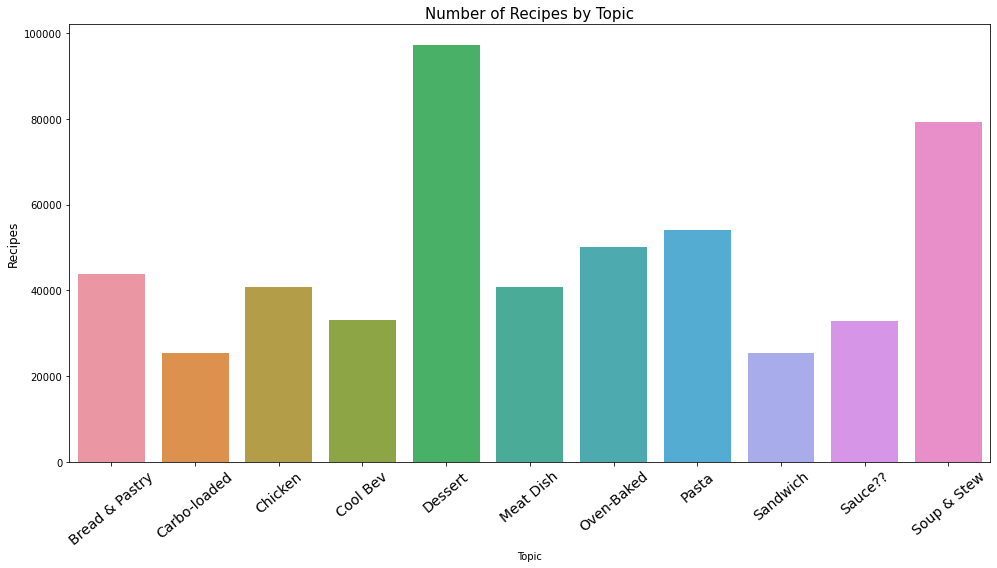

In [479]:
plt.figure(figsize=(14,8))
plt.xticks(rotation=40, fontsize=14)
plt.title('Number of Recipes by Topic', fontsize=15)
color_map = sns.color_palette("tab10", 15)
topic_barchart = sns.barplot(x='Topic', y='RecipeInstructions', data=topic_counts)
plt.ylabel('Recipes', fontsize=12)
plt.tight_layout()
plt.savefig('topic_barplot.png')


Apparently a lot of the recipes are about desserts. Since the topic 'Dessert' is one of the topics that show quite clear composition of relevant terms, I think there might actually be a lot of recipes about desserts out there. Other than that the topics' frequencies somewhat fall in a similar order of magnitude. 

I will further confirm this through clustering analysis.



#### Do the topics represent the actual recipes well?

- So, which recipes have the highest score for each topic?

In [480]:
docs_dict_test = {}
for topic_num in range(len(recipe_model.components_)):
    
    topic_name = topic_labels[topic_num]
        
    top_indices = np.argsort(recipe_model.transform(x_tfidf)[:,topic_num])[::-1]
    top_documents = []
    for doc_index in top_indices[0:3]:
        top_documents.append(df_recipe.Name[doc_index])
        
        docs_dict_test[topic_name] = top_documents  # For each topic, take top n documents and put them into a list

    print(f'{topic_name}:')
    print(docs_dict_test[topic_name])

Meat Dish:
['Cantrell Sauce (steak Marinade and Grilling Sauce)', 'Sweet and Spicy Pork Chops', "T-Bone Steak &amp; Jack Daniel's Grilling Sauce"]
Dessert:
["Decadent Devil's Food Cake", 'Vanilla Butter-Creme Chocolate Ganache Birthday Cake', 'Chocolate Sour Cream Bundt Cake']
Chicken:
['Refreshing Chicken Salad', 'Teriyaki BBQ Sauce', "Longhorn Steakhouses' Honey Mustard"]
Oven-Baked:
['Parmesan Roasted Asparagus Spears', 'Biscuit on Creamy Chicken', 'Broccoli Casserole With Rice']
Bread & Pastry:
['Foolproof  Flaky Butter Pastry', 'French Bread ("Rapid Rise")', 'Whole Wheat Crescent Rolls']
Cool Bev:
['Planters Punch', 'Daily Dose Cocktail', 'Grapefruit Rum Cooler']
Soup & Stew:
['Wild Mushroom Soup', 'Spicy Grain Soup', 'Mushroom Barley Soup']
Carbo-loaded:
["Stacey's Cheesy Potatoes", 'Baked Potatoes With Toppers', "Bea's Caesar Mashed Potatoes"]
Pasta:
["Insalata Florentine Romano's Macaroni Grill Copycat", 'Tuna and Pasta Salad', 'Rotini and Black Bean Salad']
Sauce??:
['Orange-P

At least the recipes with the highest scores seem to fit the topics reasonably well.

- Let's also check the scores for a best-matching document for each topic

In [482]:
for topic_num in range(len(recipe_model.components_)):
    
    topic_name = topic_labels[topic_num]
    top_indices = np.argsort(recipe_model.transform(x_tfidf)[:,topic_num])[::-1]
    recipe_name = df_recipe.Name.iloc[top_indices[0]]
    score = np.max(recipe_model.transform(x_tfidf)[:,topic_num])
    print(f'Top topic for {topic_name}: {recipe_name}')
    print(f'Model score: {score}')
    print('------------------------------------')

Top topic for Meat Dish: Cantrell Sauce (steak Marinade and Grilling Sauce)
Model score: 0.05509799676480944
------------------------------------
Top topic for Dessert: Decadent Devil's Food Cake
Model score: 0.07679308730243227
------------------------------------
Top topic for Chicken: Refreshing Chicken Salad
Model score: 0.11007161101868407
------------------------------------
Top topic for Oven-Baked: Parmesan Roasted Asparagus Spears
Model score: 0.08656220705002918
------------------------------------
Top topic for Bread & Pastry: Foolproof  Flaky Butter Pastry
Model score: 0.08925161738410683
------------------------------------
Top topic for Cool Bev: Planters Punch
Model score: 0.09892234305283633
------------------------------------
Top topic for Soup & Stew: Wild Mushroom Soup
Model score: 0.0693692760552689
------------------------------------
Top topic for Carbo-loaded: Stacey's Cheesy Potatoes
Model score: 0.11485584208821759
------------------------------------
Top topi

### 4a-IV. Elementary Recommendation Model (WIP)
- Didn't get to implement this feature. Still I will leave it as WIP.

My approach was to perform a topic modeling on a single document (applying the same NMF model from earlier) and then match its terms to that of the topics

In [403]:
recipe_query = df_recipe['RecipeInstructions'][95262]
recipe_query

'note these ingredient amounts are to taste you may use more or less of the seasonings to fit your tastebuds adjust the recipe to fit how many people youll be serving   potatoes should be enough to serve two people as a side dish or snack i also used nonstick cooking spray instead of oil because i have ibs and have to watch my fat intake my ibs tolerated the potato skin too although normally i stay away from potato skin which i love scrub the baking potatoes and leave the skin on you can peel these if you want i didnt have a vegetable peeler and i cant peel skin well with a paring knife and i like the taste of the skin for these fries cut potatoes lengthwise then lay the halves flat side down and cut into  inch s then cut the s so they are about  inch wide place the potato pieces in a bowl with lid i used a  gladware bowl mix in a separate  bowl all the spices spray the potatoes in the bowl generously with nonstick cooking spray sprinkle the spices over the pamcoated potatoes and cover

In [404]:
recipe_query_clean = lemm_docs(recipe_query)
recipe_query_clean = word_tokenize(recipe_query)
recipe_query_clean

['note',
 'these',
 'ingredient',
 'amounts',
 'are',
 'to',
 'taste',
 'you',
 'may',
 'use',
 'more',
 'or',
 'less',
 'of',
 'the',
 'seasonings',
 'to',
 'fit',
 'your',
 'tastebuds',
 'adjust',
 'the',
 'recipe',
 'to',
 'fit',
 'how',
 'many',
 'people',
 'youll',
 'be',
 'serving',
 'potatoes',
 'should',
 'be',
 'enough',
 'to',
 'serve',
 'two',
 'people',
 'as',
 'a',
 'side',
 'dish',
 'or',
 'snack',
 'i',
 'also',
 'used',
 'nonstick',
 'cooking',
 'spray',
 'instead',
 'of',
 'oil',
 'because',
 'i',
 'have',
 'ibs',
 'and',
 'have',
 'to',
 'watch',
 'my',
 'fat',
 'intake',
 'my',
 'ibs',
 'tolerated',
 'the',
 'potato',
 'skin',
 'too',
 'although',
 'normally',
 'i',
 'stay',
 'away',
 'from',
 'potato',
 'skin',
 'which',
 'i',
 'love',
 'scrub',
 'the',
 'baking',
 'potatoes',
 'and',
 'leave',
 'the',
 'skin',
 'on',
 'you',
 'can',
 'peel',
 'these',
 'if',
 'you',
 'want',
 'i',
 'didnt',
 'have',
 'a',
 'vegetable',
 'peeler',
 'and',
 'i',
 'cant',
 'peel',
 's

In [405]:
query_vect = tfidf.fit_transform(recipe_query_clean)
query_vect

<407x1 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [406]:
query_model = nmf_sklearn.fit(query_vect)
query_model_trans = query_model.transform(query_vect)
query_model_trans.shape

c:\Users\Hyosang-PC\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(407, 11)

In [408]:
tfidf.get_feature_names()

['fries']

In [407]:
def get_topic_terms_all(model, vectorizer):

    #print(f'Here are top {top_n_terms} most contributing terms for each topic:')
    #print('\n')
    
    vect_feature_names = vectorizer.get_feature_names()
    topics_dict = {}
    for topic_num in range(len(model.components_)):
    
        topic_name = topic_labels[topic_num]
        top_term_indices = np.argsort(model.components_[topic_num,:])[::-1]   # Sorts terms in topic_num'th Topic. 
        top_terms = []
        for term_idx in top_term_indices[0:]:
            top_terms.append(vect_feature_names[term_idx])
        
            topics_dict[topic_name] = top_terms  # For each topic, take top n terms and put them into a list

        #print(f'{topic_name}:')
        #print(topics_dict[topic_name])
       
    return topics_dict

In [401]:
terms_dictionary = get_topic_terms_all(recipe_model, tfidf)

## 4b. LDA

In [181]:
lda_sk = LatentDirichletAllocation(n_components=11, learning_method='online', random_state=123, n_jobs=-1, verbose=1)  #online is faster

In [207]:
lda_sk2 = LatentDirichletAllocation(n_components=6, learning_method='online', random_state=123, n_jobs=-1, verbose=1)  #online is faster
recipe_model_lda2 = lda_sk2.fit(x_tfidf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [209]:
lda_sk3 = LatentDirichletAllocation(n_components=20, learning_method='online', random_state=123, n_jobs=-1, verbose=1)  #online is faster
recipe_model_lda3 = lda_sk3.fit(x_tfidf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [198]:
recipe_model_lda = lda_sk.fit(x_tfidf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [212]:
with open("recipe_model_lda","wb") as f:
    dill.dump(recipe_model_lda, f)
    
with open("recipe_model_lda2","wb") as f:
    dill.dump(recipe_model_lda2, f)
    
with open("recipe_model_lda3","wb") as f:
    dill.dump(recipe_model_lda3, f)

In [424]:
recipe_model_lda_transform = recipe_model_lda.transform(x_tfidf)

ValueError: X has 478 features, but LatentDirichletAllocation is expecting 497 features as input.

In [419]:
lda_topic_terms = get_topic_terms(recipe_model_lda, tfidf, top_n_terms=10)

Here are top 10 most contributing terms for each topic:




IndexError: list index out of range

In [417]:
#lda_topic_labels = ['Pasta', 'Dessert', 'Chicken', 'Oven-Baked', 'Bread & Pastry', 'Cool Bev', 'Soup & Stew', 'Carbo-loaded', 'Meat Dish', 'Sauce?', 'Salad']
lda_topic_labels = ['Dessert_Cake', 'Cool Bev', 'Oven-Baked', 'Salad', 'Chicken', 'Dessert_Confection', 'Meats', 'Bread', 'Snack', 'Mystery1', 'Mystery2']
for count, topic_name in enumerate(lda_topic_terms):
    lda_topic_terms[topic_labels[count]] = lda_topic_terms.pop(topic_name)

In [418]:
lda_topic_table = pd.DataFrame.from_dict(lda_topic_terms).rename_axis(index='Term Rank').reset_index()
lda_topic_table

,Term Rank,Pasta,Dessert,Chicken,Oven-Baked,Bread & Pastry,Cool Bev,Soup & Stew,Carbo-loaded,Meat Dish,Sauce?,Salad
0,0,batter,blender,cheese,chicken,chicken,chocolate,pork,dough,tortilla,shake,potatoes
1,1,beat,ice,bread,grill,simmer,cream,beans,roll,salsa,enjoy,fish
2,2,flour,glass,dish,dressing,sauce,pie,hours,sheet,chips,jar,taste
3,3,cake,blend,sprinkle,marinade,boil,crust,soak,cookie,chill,store,cut
4,4,eggs,juice,degrees,salad,pot,cool,overnight,balls,peanut,container,garlic
5,5,vanilla,smooth,spread,toss,garlic,milk,rinse,flour,lettuce,lid,olive
6,6,cool,apples,bacon,fridge,onion,syrup,fat,shape,fold,use,juice
7,7,muffin,processor,casserole,bag,skillet,saucepan,approximately,inch,extra,tightly,lemon
8,8,dry,food,spray,hours,rice,vanilla,inches,cut,square,color,use
9,9,egg,pineapple,slices,refrigerate,bring,stirring,board,ball,toothpick,teaspoons,chop


In [216]:
lda_docs_dict = {}
for topic_num in range(len(recipe_model_lda.components_)):
    
    #topic_name = topic_labels[topic_num]
    topic_name = 'Topic #'+ str(topic_num+1)
        
    top_indices = np.argsort(recipe_model_lda.transform(x_tfidf)[:,topic_num])[::-1]
    top_documents = []
    for doc_index in top_indices[0:5]:
        top_documents.append(df_recipe.Name[doc_index])
        
        lda_docs_dict[topic_name] = top_documents  # For each topic, take top n terms and put them into a list

    print(f'{topic_name}:')
    print(lda_docs_dict[topic_name])

Topic #1:
['Copycat Cracker Barrel 40th Anniversary Double Fudge Cola Cake', 'Banana Caramel Cake With Mascarpone Frosting', "Georgetown Cupcake's Chocolate Ganache Cupcakes", 'Mini Dark Chocolate Fudge Peppermint Cakes', 'Lemon Meringue Cake']
Topic #2:
['Mixed-Fruit Smoothies', 'Banana Punch', 'Banana Brunch Punch', 'Banana Punch', 'Cucumber Gimlets']
Topic #3:
['Sausage and Egg Brunch Bake', 'Zucchini Flats', "Kittencal's Holiday Brunch Sausage Casserole", 'Soft & Cheesy Breakfast Casserole', 'Open-Faced Philly Sandwiches']
Topic #4:
['Grilled Chicken Pitas', 'Grilled Chipotle Chicken', "Ana's Asian Ny Strip Steak", 'Honey Soy Salmon', 'Chili and Garlic-Rubbed Steaks']
Topic #5:
["Poularde a L'ivoire (Ivory Chicken)", 'Texas Beef Chili With Poblanos and Beer', 'Ultimate Beef Stew - Tyler Florence', 'Fettuccine Alla Chunky &amp; Zesty Bolognese Sauce', 'Chicken Delmonico']
Topic #6:
['Chocolate Chambord Cheesecake', 'Homemade marshmallows', 'Lemon Mascarpone Crepe Cake', 'Banana Crea

### 4b-I. Using pyLDAvis to see if the topics are well separated, and analyze which terms forms the majority of each topic. 

In [211]:
#https://we1s.ucsb.edu/research/we1s-tools-and-software/topic-model-observatory/tmo-guide/tmo-guide-pyldavis/
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_sk, x_tfidf, tfidf, mds='tsne', n_jobs=-1)

c:\Users\Hyosang-PC\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
c:\Users\Hyosang-PC\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      158.304245  152.859161       1        1  25.675263
0     -154.908630  -15.818744       2        1  12.553027
10    -213.980865  376.240234       3        1  11.575669
5      378.758820 -486.598969       4        1  11.497617
2     -381.861908 -316.007904       5        1  10.623589
7      148.385742  530.916138       6        1  10.029975
3      -51.129013 -527.202759       7        1   7.077386
1      137.890610 -201.229828       8        1   4.773431
9     -511.841278   96.375031       9        1   2.085814
8      509.044678  293.871857      10        1   2.061246
6      518.291443  -99.628937      11        1   2.046982, topic_info=         Term          Freq         Total Category  logprob  loglift
307      pork  22347.000000  22347.000000  Default  30.0000  30.0000
22      beans  18827.000000  18827.000000  Default  29.0000  29.0000
454  tortilla  14050.000000  14050.000000  Default  28.0000  28.0000
143     enjoy  14069.000000  14069.000000  Default  27.0000  27.0000
67      chips  12843.000000  12843.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
124  dissolve      0.408768   1740.233260  Topic11 -11.6228  -4.4676
371   shallow      0.408756   2737.436645  Topic11 -11.6228  -4.9206
119     diced      0.408732   1968.148589  Topic11 -11.6229  -4.5907
480       wet      0.408723   2731.837749  Topic11 -11.6229  -4.9186
193     hands      0.408717   2150.768872  Topic11 -11.6229  -4.6795

[546 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3         1  0.457965    adjust
3         2  0.053485    adjust
3         3  0.454622    adjust
3         4  0.032951    adjust
4         2  0.104154  airtight
...     ...       ...       ...
493       7  0.140299    yogurt
493       8  0.521586    yogurt
494       2  0.380774     yolks
494       3  0.142731     yolks
494       4  0.475609     yolks

[1823 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 11, 6, 3, 8, 4, 2, 10, 9, 7])

- Although LDA lets me use some nice visualizations that allow me to evaluate its model quality and term distributions, the topics were more difficult to interpret (i.e. label appropriate names). Also, best matching recipes for the topics did not really reflect the topics well.<br>
Therefore, I have dicided to use NMF as the topic model of choice.